In [73]:
import pandas as pd
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import scipy.stats as ss
import numpy as np

In [74]:
df = pd.read_csv('./data/all_portal_data_cleaned.csv')

In [75]:
df['firsttime'] = pd.to_datetime(df['firsttime'])
df['lasttime'] = pd.to_datetime(df['lasttime'])
df.head()

,id,firsttime,lasttime,response,ip,as,domain,country,source,inetnum,netname
0,198137,2011-09-27 13:10:18,2012-03-25 08:17:41,dead,222.165.135.195,AS9329,wpc.gov.lk,LK,APNIC,222.165.135.0 - 222.165.135.255,CUS-LAN-SLT-LK
1,198193,2011-09-27 13:10:19,2013-06-24 17:22:49,dead,74.53.224.194,AS32613,hospitalsanbernabe.gov.co,US,ARIN,198.50.100.48 - 198.50.100.55,IWEB-CL-T118-490CL-1414
2,198221,2011-09-27 13:10:19,2014-01-26 19:16:56,dead,210.56.24.2,AS7590,un.org.pk,PK,APNIC,210.56.0.0 - 210.56.31.255,COMSATS
3,198341,2011-09-27 13:10:20,2013-02-22 04:40:33,dead,84.51.33.86,AS34104,espiyemeb.gov.tr,TR,RIPE,84.51.33.0 - 84.51.33.255,MARKUM_BILISIM_3
4,198382,2011-09-27 13:10:21,2012-03-03 12:38:32,dead,74.53.224.194,AS21844,hospitalsanbernabe.gov.co,US,ARIN,74.52.0.0 - 74.53.255.255,NETBLK-THEPLANET-BLK-14


In [76]:
# split in alive and dead 
df_alive = df.loc[df['response'] == 'alive']
df_dead = df.loc[df['response'] == 'dead']
print(df.shape)
print(df_alive.shape)
print(df_dead.shape)

(873984, 11)
(51535, 11)
(817303, 11)


In [77]:
def time_delta_to_days(row):
    delta = row.lasttime - row.firsttime
    delta = delta.days
    return delta

In [78]:
# calculate lifetime
df_dead['lifetime'] = df_dead.apply(time_delta_to_days, axis=1)

In [79]:
df_dead.shape

(817303, 12)

In [80]:
# filter out outliers
df_dead['z_score'] = df_dead.groupby('as')['lifetime'].apply(lambda x: (x-x.mean())/x.std())
df_dead = df_dead[abs(df_dead['z_score']) <3]

In [81]:
df_dead.shape

(794330, 13)

In [82]:
# calculate mean lifetime per AS
means = df_dead.groupby('as')['lifetime'].mean(numeric_only=False)
counter = Counter(df_dead['as'])

# filter out ASs with less than 100 incidents
AS_lifetime = pd.DataFrame(means.sort_values())
AS_lifetime['num_incidents'] = AS_lifetime.apply(lambda row: counter[row.name], axis=1)
AS_lifetime = AS_lifetime.loc[AS_lifetime['num_incidents'] >= 100]
AS_lifetime.shape

(861, 2)

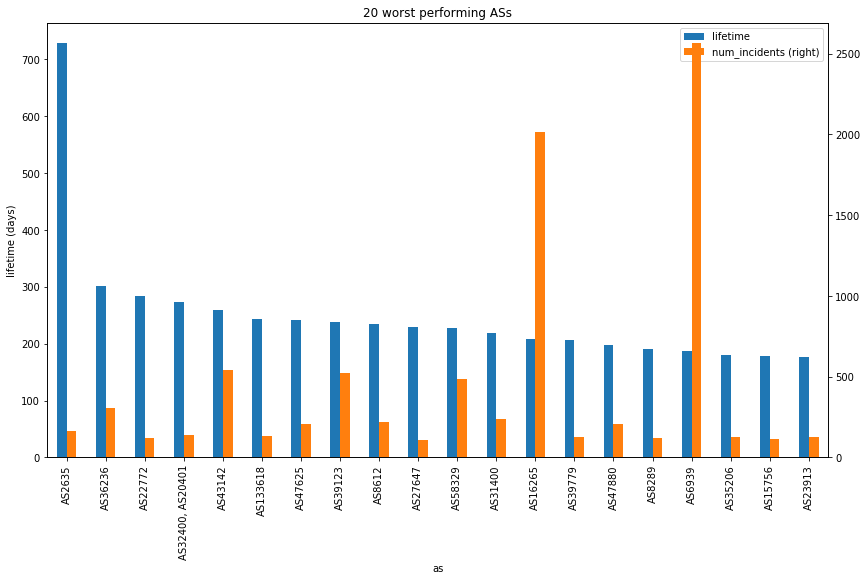

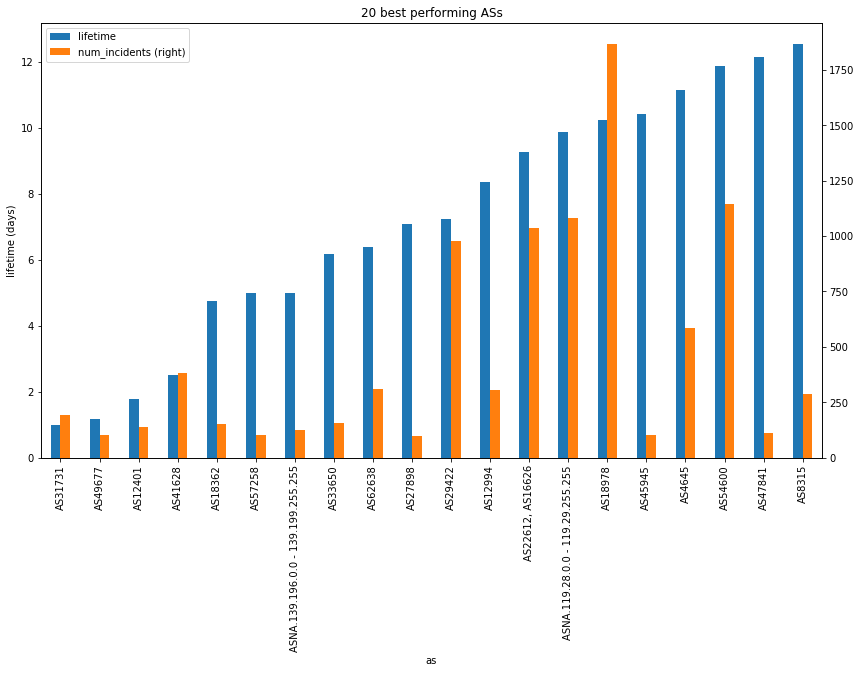

In [102]:
plot = AS_lifetime.sort_values(by=['lifetime'], ascending=0)[0:20].plot(kind='bar', secondary_y='num_incidents',figsize=(14,8), title='20 worst performing ASs')
plot.set_ylabel('lifetime (days)')
fig = plot.get_figure()
fig.savefig('worst_20.png', bbox_inches = "tight")

plot = AS_lifetime.sort_values(by=['lifetime'])[0:20].plot(kind='bar', secondary_y='num_incidents',figsize=(14,8), title='20 best performing ASs')
plot.set_ylabel('lifetime (days)')
fig = plot.get_figure()
fig.savefig('best_20.png', bbox_inches = "tight")
